## Calculating likelihoods

In [1]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch
import time
from scipy.special import logsumexp

import sys

sys.path.append('../')
from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs

from sample import sample

glasflow is using its own internal version of nflows


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [248]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', None)

model_names, flow = read_models.get_models(file_path, ['CE'], params, use_flows=True, device='cpu')
_, KDE = read_models.get_models(file_path, ['CE'], params, use_flows=False, device='cpu')

100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


## Likelihoods In sampling

In [249]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [250]:
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/flow_models/cosmo_weights/newmappings/"
flow['CE'].load_model(flow_path, 'CE')

In [258]:
lnlike_flow=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        lnlike_flow[chibid,alphaid]=sample.lnlike([chibid,alphaid],obsdata, flow, submodels_dict, ['CE'], use_flows=True)

In [6]:
lnlike_flow

array([[-173.12040062, -155.03684912, -118.40810846, -112.83087088,
        -165.83597968],
       [-179.7249909 , -176.07320902, -129.75042404, -103.92826212,
        -151.41989804],
       [-225.06919893, -211.71301244, -173.86509907, -157.87251607,
        -172.78022618],
       [-482.45723995, -428.1226933 , -378.411232  , -312.60461757,
        -469.58454482]])

Text(0.5, 1.0, 'CE channel likelihoods (flow)')

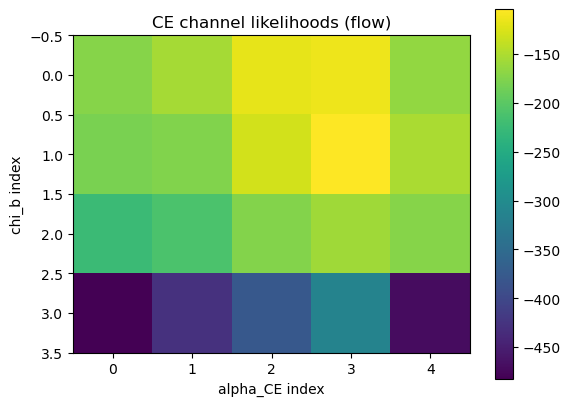

In [7]:
plt.imshow(lnlike_flow)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (flow)')

In [291]:
mchirps = np.linspace(0.1,99.9,5)
qs = np.linspace(0.01,0.99,5)
chieffs = np.linspace(-0.99,0.99,5)
zs = np.linspace(0.1,9.9, 5)
param_grid = np.array(np.meshgrid(mchirps,qs,chieffs,zs)).T.reshape(1,-1,4)

mapped_sample = flow['CE'].map_obs(param_grid)

ptheta_achi_flow=np.zeros((4,5))
for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        test_conditional=np.reshape((np.tile([xb,a],np.shape(param_grid)[1])),(1,-1,2))
        ptheta_achi_flow_persamp=flow['CE'].flow.get_logprob(param_grid, mapped_sample, test_conditional)
        ptheta_achi_flow[chibid,alphaid] = logsumexp(ptheta_achi_flow_persamp)

In [293]:
ptheta_achi_flow

array([[ 3.11792374,  3.89550066,  4.69418859,  3.73168111,  3.82067871],
       [ 3.56506777,  4.01247787,  2.65666676,  2.40267944, -0.26037031],
       [ 3.10783601,  3.9321692 ,  2.56621981,  2.3189528 , -0.09017229],
       [ 1.84639764,  3.45078182,  4.04620695,  5.17186546,  4.47548485]])

Text(0.5, 1.0, 'p(theta|alpha,chi_b), CE channel (flow)')

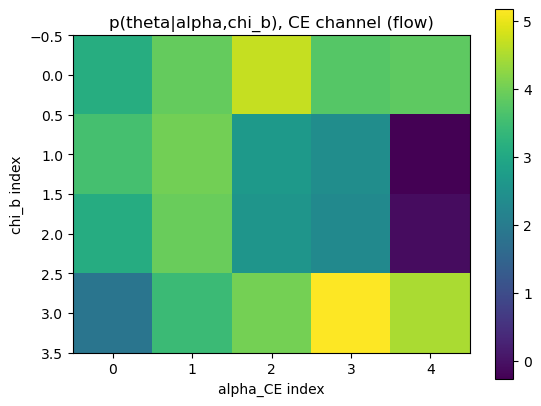

In [287]:
plt.imshow(ptheta_achi_flow)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('p(theta|alpha,chi_b), CE channel (flow)')

In [295]:
ptheta_achi_kde=np.zeros((4,5))
for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        submodels_dict
        ptheta_achi_kde_persamp=np.log(KDE['CE'][submodels_dict[0][chibid]][submodels_dict[1][alphaid]].pdf(param_grid[0]))
        ptheta_achi_kde[chibid,alphaid] = logsumexp(ptheta_achi_kde_persamp)

/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_61075/2216055882.py:5: RuntimeWarning: divide by zero encountered in log
  ptheta_achi_flow_persamp=np.log(KDE['CE'][submodels_dict[0][chibid]][submodels_dict[1][alphaid]].pdf(param_grid[0]))


In [297]:
ptheta_achi_flow

array([[ -2.94597544,  -3.09499201,  -1.40404936,  -2.46337987,
         -2.82820814],
       [ -4.19619026,  -2.80592617,  -5.58690062,  -6.07759583,
        -13.17937801],
       [ -5.39755949,  -2.45735441,  -5.23416282,  -1.96636708,
        -14.34751345],
       [ -3.62476032,  -1.54289873,  -1.33129668,  -2.80950997,
         -3.04499186]])

Text(0.5, 1.0, 'p(theta|alpha,chi_b), CE channel (kde)')

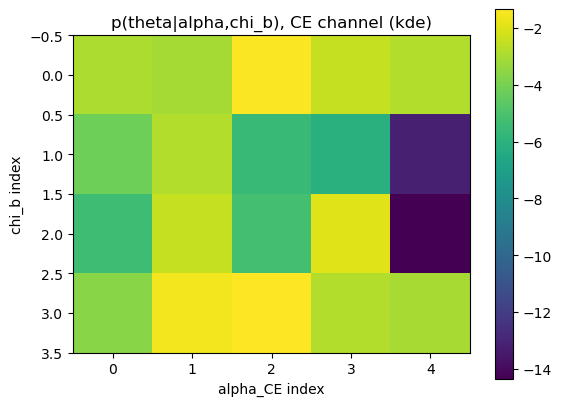

In [298]:
plt.imshow(ptheta_achi_flow)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('p(theta|alpha,chi_b), CE channel (kde)')

In [6]:
flow['CE'].flow.get_logprob(test_sample, mapped_sample,test_conditional)

torch.Size([1, 3, 4])


array([[  1.4539537, -26.758013 , -26.757986 ]], dtype=float32)

In [26]:
np.log(KDE['CE']['chi01']['alpha05'].pdf(test_sample[0]))

array([ -6.45597289, -21.57828324])

## Testing int(p(theta|alpha,chi)dtheta) =1

In [174]:
mchirps = np.linspace(0.1,99.9,20)
qs = np.linspace(0.01,0.99,20)
chieffs = np.linspace(-0.99,0.99,20)
zs = np.linspace(0.1,9.9, 20)

param_grid = np.array(np.meshgrid(mchirps,qs,chieffs,zs)).T.reshape(1,-1,4)

In [175]:
mapped_param_grid = flow['CE'].map_obs(param_grid)

In [176]:
mapped_param_grid

array([[[ 13.66493092,  -0.34427877,  -2.64665241,  -0.32739101],
        [ 13.66493092,  -0.20408034,  -2.64665241,  -0.32739101],
        [ 13.66493092,  -0.15425705,  -2.64665241,  -0.32739101],
        ...,
        [-13.66493092,   0.15425705,   2.64665241,   0.32739101],
        [-13.66493092,   0.20408034,   2.64665241,   0.32739101],
        [-13.66493092,   0.34427877,   2.64665241,   0.32739101]]])

In [187]:
dtheta = np.prod(np.diff(mapped_param_grid, axis=1), axis=-1)
dtheta = np.reshape(np.append(dtheta,0), (160000))
dmdqdchidz = 16*(np.max(mapped_param_grid[:,:,0]))*(np.max(mapped_param_grid[:,:,1]))*(np.max(mapped_param_grid[:,:,2])) *\
                (np.max(mapped_param_grid[:,:,3]))

In [80]:
mapped_param_grid.shape

(1, 160000, 4)

In [274]:
conds= np.reshape((np.tile([0.5,0.2],np.shape(param_grid)[1])),(1,-1,2))

In [275]:
log_prob_grid=flow['CE'].flow.get_logprob(param_grid, mapped_param_grid, conds)

In [284]:
logsumexp((log_prob_grid+ np.log(dtheta)))

/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_61075/3347962205.py:1: RuntimeWarning: divide by zero encountered in log
  logsumexp((log_prob_grid+ np.log(dtheta)))


-732.9230344525499

In [278]:
probs, dx=np.linspace(0,5,10000, retstep=True)

#this is log(probs*normalisation constant)
test_lprobs=np.log(probs)+np.log(2/50000)
logsumexp(test_lprobs)

/var/folders/t1/pzgx3lnj70l28d88_yvswpsr0000gq/T/ipykernel_61075/656039321.py:4: RuntimeWarning: divide by zero encountered in log
  test_lprobs=np.log(probs)+np.log(2/50000)


-7.60080245454175

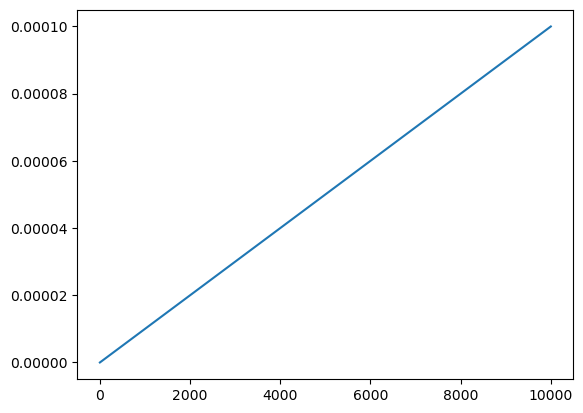

In [238]:
plt.plot(probs/50000)

In [216]:
from scipy import integrate
def f(mchirp, q,chieff,z):
    params= np.asarray([mchirp, q,chieff,z])
    params = np.reshape(params, (1,1,4))
    mapped_params = flow['CE'].map_obs(params)
    return flow['CE'].flow.get_logprob(params, mapped_params, np.asarray([[[0.,0.2]]]))
def bounds_mchirp():
    return [0., 100.]
def bounds_q():
    return [0., 1.]
def bounds_chieff():
    return [-1., 1.]
def bounds_z():
    return [0., 10.]

In [217]:
integrate.nquad(f, [[0., 100.], [0., 1.], [-1., 1.], [0., 10.]])

/Users/stormcolloms/opt/anaconda3/envs/amaze/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


KeyboardInterrupt: 

In [18]:
from functools import reduce
import operator
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

In [8]:
lnlike_kde=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        lnlike_kde[chibid,alphaid]=sample.lnlike([chibid,alphaid,1.],obsdata, KDE, submodels_dict, ['CE'], use_flows=False)

['CE', 'chi00', 'alpha02']
1.0
0.0
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf]
[2.56517013e-03 9.57339440e-04 2.04189627e-03 5.97370864e-04
 1.30881890e-06 9.97676828e-04 2.25321117e-04 2.90513956e-19
 8.44569018e-06 3.70976316e-03 6.25580970e-04 1.15266243e-03
 1.79879578e-03 1.29644192e-04 1.22479564e-03 4.39814303e-04
 7.37576493e-04 1.84211706e-03 2.76904710e-02 8.21421678e-04
 1.03007113e-03 3.95796739e-04 4.18311326e-03 1.91931238e-02
 7.41726057e-04 2.96271225e-03 2.10807336e-05 1.36417313e-04
 1.75394269e-04 1.55427428e-03 3.93878213e-03 1.10706202e-03
 1.50945724e-03 3.29745043e-02 7.00538159e-04 6.03854243e-04
 1.48881486e-03 9.94733895e-08 3.84059209e-02 1.00000000e-50
 6.41952899e-04 3.34538753e-04 2.41461653e-02 1.09707441e-10
 2.07496872e-03 2.72256801e-04]
[  -5.96573047   -6.9513525

In [14]:
lnlike_kde = np.load('CE_lnlike_kde.npy')

Text(0.5, 1.0, 'CE channel likelihoods (KDEs)')

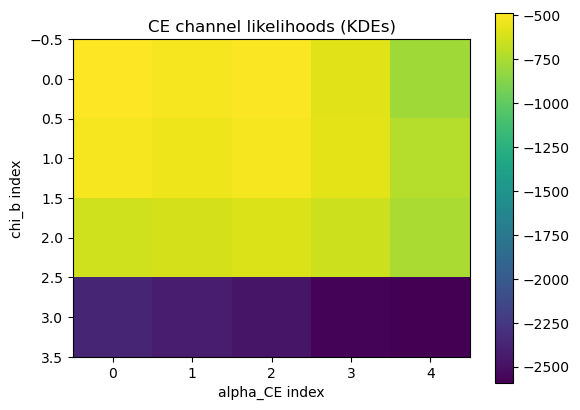

In [21]:
plt.imshow(lnlike_kde)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (KDEs)')

In [15]:
lnlike_kde

array([[ -488.54896481,  -516.01045514,  -497.21744547,  -580.29421382,
         -786.29323308],
       [ -517.44113865,  -539.3906847 ,  -521.00342875,  -575.61471784,
         -720.9136174 ],
       [ -638.6766879 ,  -624.86668284,  -599.60617914,  -649.87875854,
         -752.67508215],
       [-2372.87555011, -2421.31486477, -2474.83763468, -2571.90109638,
        -2591.77152278]])